In [1]:
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import clone_model
from matplotlib import pyplot
from numpy import average
from numpy import array

Using TensorFlow backend.


In [2]:
# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'model_' + str(epoch) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('> Loaded %s' % filename)
    return all_models

In [3]:
# create a model from the weights of multiple models
def model_weight_ensemble(members, weights):
    # determine how many layers need to be averaged
    n_layers = len(members[0].get_weights())
    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = array([model.get_weights()[layer] for model in members])
        # weighted average of weights for this layer
        avg_layer_weights = average(layer_weights, axis=0, weights=weights)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)
    # create a new model with the same structure
    model = clone_model(members[0])
    # set the weights in the new
    model.set_weights(avg_model_weights)
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['accuracy'])
    return model

In [4]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testY):
    # select a subset of members
    subset = members[:n_members]
    # prepare an array of equal weights
    weights = [1.0/n_members for i in range(1, n_members+1)]
    # create a new model with the weighted average of all model weights
    model = model_weight_ensemble(subset, weights)
    # make predictions and evaluate accuracy
    _, test_acc = model.evaluate(testX, testY, verbose=0)
    return test_acc

In [5]:
# generate 2d classification dataset
X, Y = make_blobs(n_samples=1100, centers=3, n_features=2,
                 cluster_std=2, random_state=2)
# one hot encode output variable
Y = to_categorical(Y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainY, testY = Y[:n_train], Y[n_train:]

In [6]:
# load models in order
members = load_all_models(490, 500)
print('Loaded %d models' % len(members))

W0102 13:30:00.193337 14448 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 13:30:00.215126 14448 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0102 13:30:00.288885 14448 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:178: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0102 13:30:00.291104 14448 deprecation_wrapper.py:119] From C:\Users\Lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:185: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0102 13:30:00.292278 14448 deprecation_wrapper.py:119] From C:

> Loaded model_490.h5
> Loaded model_491.h5
> Loaded model_492.h5
> Loaded model_493.h5
> Loaded model_494.h5
> Loaded model_495.h5
> Loaded model_496.h5
> Loaded model_497.h5
> Loaded model_498.h5
> Loaded model_499.h5
Loaded 10 models


In [7]:
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))

In [8]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testY)
    # evaluate model with i members
    _, single_score = members[i-1].evaluate(testX, testY, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

> 1: single=0.811, ensemble=0.811
> 2: single=0.806, ensemble=0.811
> 3: single=0.805, ensemble=0.805
> 4: single=0.803, ensemble=0.805
> 5: single=0.805, ensemble=0.803
> 6: single=0.801, ensemble=0.806
> 7: single=0.800, ensemble=0.807
> 8: single=0.801, ensemble=0.804
> 9: single=0.803, ensemble=0.805
> 10: single=0.805, ensemble=0.803


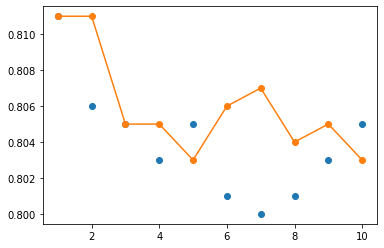

In [9]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()